# Box Spread Treasury Trading

The overall goal is to use the Kalman Smoothing on the convenience yield to trade the residuals across various Treasury Futures

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

from   DataCollect import BoxSpreadData
from   tsmoothie.smoother import KalmanSmoother

## Get Data and Exploratory Data Analysis

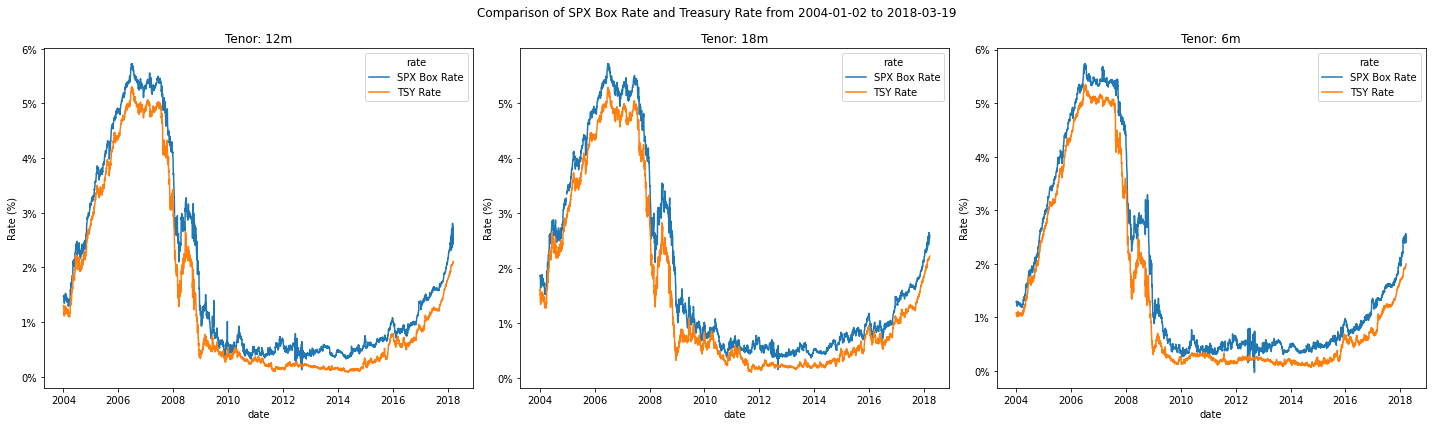

In [2]:
def plot_rate_comparison(df_box: pd.DataFrame) -> pd.DataFrame:

    tenors = df_box.tenor.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(tenors), figsize = (20,6))

    for tenor, ax in zip(tenors, axes.flatten()):

        (df_box.query(
            "tenor == @tenor").
            set_index("date")
            [["box", "gov"]].
            rename(columns = {
                "box": "SPX Box Rate",
                "gov": "TSY Rate"}).
            plot(
                ax = ax,
                title = "Tenor: {}".format(tenor),
                ylabel = "Rate (%)"))
        
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

    fig.suptitle("Comparison of SPX Box Rate and Treasury Rate from {} to {}".format(
        df_box.date.min(),
        df_box.date.max()))

    plt.tight_layout()

plot_rate_comparison(BoxSpreadData().get_box_spread())

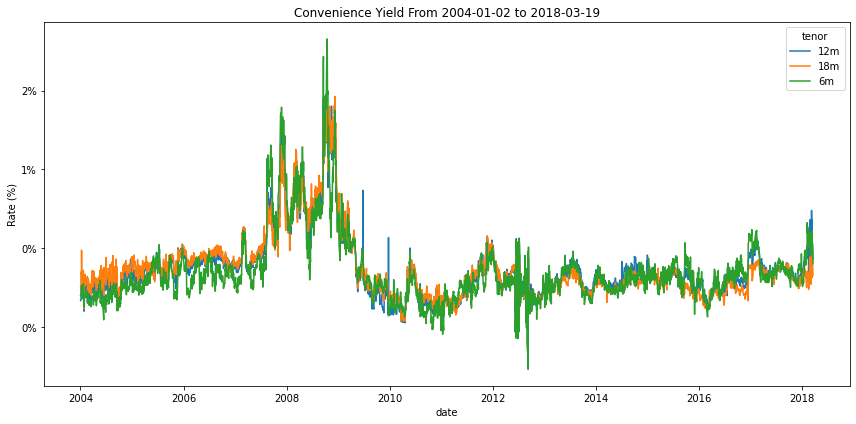

In [3]:
def plot_box_spread(df_box_spread: pd.DataFrame) -> pd.DataFrame: 
    
    _, axes = plt.subplots(figsize = (12,6))

    (df_box_spread.drop(
        columns = ["box", "gov"]).
        pivot(index = "date", columns = "tenor", values = "spread").
        plot(
            ax = axes,
            ylabel = "Rate (%)",
            title = "Convenience Yield From {} to {}".format(
                df_box_spread.date.min(),
                df_box_spread.date.max())))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    plt.tight_layout()

plot_box_spread(BoxSpreadData().get_box_spread())

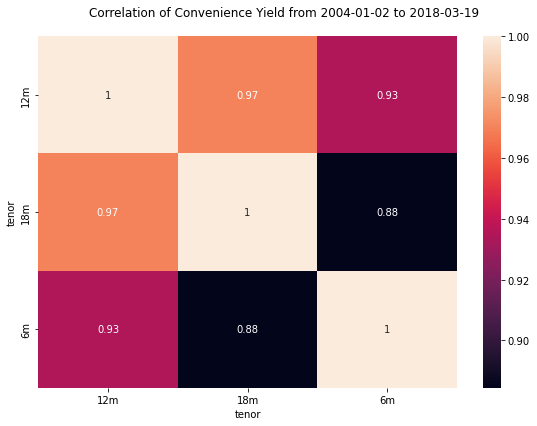

In [4]:
def plot_convenience_yield_correlation(df_box: pd.DataFrame) -> plt.Figure:

    df_corr = (df_box[
        ["date", "tenor", "spread"]].
        pivot(index = "date", columns = "tenor", values = "spread").
        corr())

    fig, axes = plt.subplots(figsize = (8,6))
    sns.heatmap(
        data = df_corr,
        ax = axes,
        annot = True)

    fig.suptitle("Correlation of Convenience Yield from {} to {}".format(
        df_box.date.min(),
        df_box.date.max()))
    
    plt.tight_layout()
    
plot_convenience_yield_correlation(BoxSpreadData().get_box_spread())

## Kalman Smoothing

Using the ```tsmoothie``` ```KalmanSmoother``` method with level set at ```0.1``` and trend set at ```0.1``` which is what they use in the GitHub example, and then use 10d EWMA Z-Score of the residual

In [5]:
def _get_kalman_residual(df: pd.DataFrame, window: int = 5) -> pd.DataFrame: 

    df_tmp = df.sort_values("date")
    smoother = KalmanSmoother(component = "level", component_noise={'level':0.1, 'trend':0.1})
    smoother.smooth(df_tmp.spread)

    df_out = (df_tmp.assign(
        smooth     = smoother.smooth_data[0],
        resid      = lambda x: x.spread - x.smooth,
        resid_mean = lambda x: x.resid.ewm(span = window, adjust = False).mean(),
        resid_std  = lambda x: x.resid.ewm(span = window, adjust = False).std(),
        zscore     = lambda x: (x.resid - x.resid_mean) / x.resid_std,
        lag_zscore = lambda x: x.zscore.shift()))
    
    return df_out

def get_kalman_residual(df_box: pd.DataFrame) -> pd.DataFrame: 

    df_resid = (df_box.groupby(
        "tenor").
        apply(_get_kalman_residual).
        reset_index(drop = True))
    
    return df_resid

df_resid = get_kalman_residual(BoxSpreadData().get_box_spread())

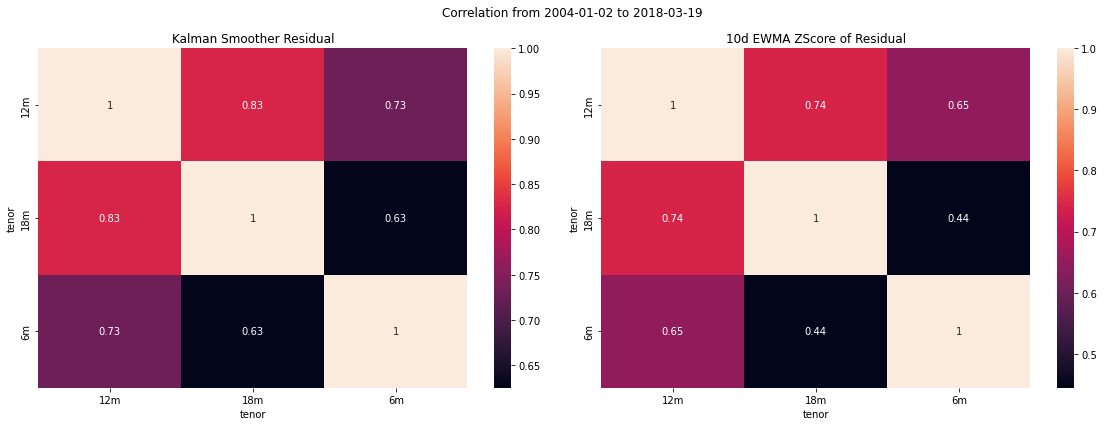

In [6]:
def plot_kalman_correlation(df_resid: pd.DataFrame) -> plt.Figure: 
    
    cols = ["resid", "zscore"]
    renamer = {
        "resid": "Kalman Smoother Residual",
        "zscore": "10d EWMA ZScore of Residual"}

    fig, axes = plt.subplots(ncols = len(cols), figsize = (16, 6))
    for col, ax in zip(cols, axes.flatten()):

        df_corr = (df_resid[
            ["date", "tenor", col]].
            pivot(index = "date", columns = "tenor", values = col).
            corr())

        sns.heatmap(
            data = df_corr,
            ax = ax,
            annot = True)

        ax.set_title(renamer[col])

    fig.suptitle("Correlation from {} to {}".format(
        df_resid.date.min(),
        df_resid.date.max()))

    plt.tight_layout()
    
plot_kalman_correlation(df_resid)

In this case the Treasury model will trade the Treasury based on the sign of the lagged zscore. To make things simple the signal will not be optimized for a specific threshold of the zscore. 

In [7]:
def apply_signal(df_tsy: pd.DataFrame, df_resid: pd.DataFrame) -> pd.DataFrame: 

    df_signal = (df_resid.merge(
        right = df_tsy, how = "inner", on = ["date"]).
        assign(strat = lambda x: x.security + " " + x.tenor)
        [["date", "tenor", "security", "lag_zscore", "PX_RTN", "PX_BPS", "strat"]].
        melt(id_vars = ["date", "tenor", "security", "lag_zscore", "strat"]).
        assign(signal_rtn = lambda x: -1 * np.sign(x.lag_zscore) * x.value))
    
    return df_signal

df_signal = apply_signal(BoxSpreadData().get_tsy_fut(), df_resid)

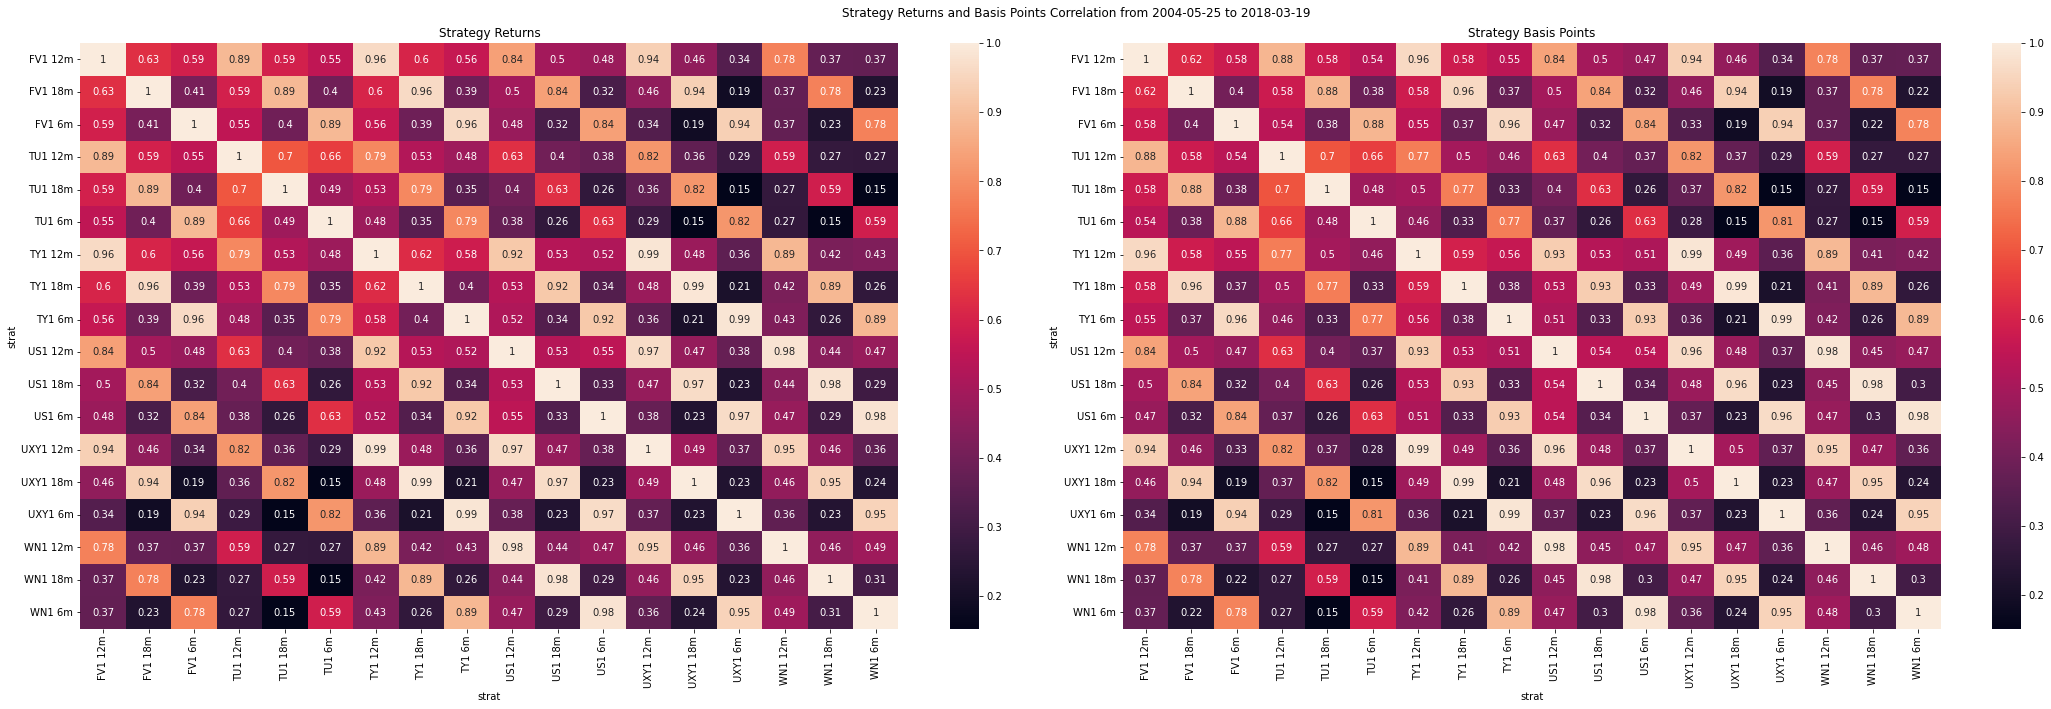

In [8]:
def plot_signal_correlation(df_signal: pd.DataFrame) -> plt.Figure: 
    
    rtn_types = df_signal.variable.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(rtn_types), figsize = (30,10))

    renamer = {
        "PX_RTN": "Strategy Returns",
        "PX_BPS": "Strategy Basis Points"}
    for rtn_type, ax in zip(rtn_types, axes.flatten()):

        df_corr = (df_signal.query(
            "variable == @rtn_type")
            [["date", "strat", "signal_rtn"]].
            pivot(index = "date", columns = "strat", values = "signal_rtn").
            corr())

        sns.heatmap(
            data = df_corr,
            annot = True,
            ax = ax)

        ax.set_title(renamer[rtn_type])

    fig.suptitle("Strategy Returns and Basis Points Correlation from {} to {}".format(
        df_signal.date.min(),
        df_signal.date.max()))
    
    plt.tight_layout()
    
plot_signal_correlation(df_signal)

In [9]:
def _get_avg_correlation(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df[
        ["date", "tenor", "signal_rtn"]].
        pivot(index = "date", columns = "tenor", values = "signal_rtn").
        corr().
        reset_index().
        melt(id_vars = "tenor").
        value.
        mean())

def get_avg_correlation(df_signal: pd.DataFrame) -> pd.DataFrame: 

    variables = df_signal.variable.drop_duplicates().to_list()

    avgs = [df_signal.query(
        "variable == @variable")
        [["date", "strat", "signal_rtn"]].
        pivot(index = "date", columns = "strat", values = "signal_rtn").
        corr().
        reset_index().
        melt(id_vars = "strat").
        query("value != 1").
        value.
        mean()
        for variable in variables]

    df_full = (pd.DataFrame({
        "rtn_type": variables,
        "avg_corr": avgs}).
        assign(group = "All Strats"))

    df_group = (df_signal.assign(
        tmp_group = lambda x: x.security + " " + x.variable).
        groupby("tmp_group").
        apply(_get_avg_correlation).
        to_frame(name = "avg_corr").
        reset_index().
        assign(
            rtn_type = lambda x: x.tmp_group.str.split(" ").str[1],
            group = lambda x: x.tmp_group.str.split(" ").str[0]).
        drop(columns = ["tmp_group"]))
    
    df_out = pd.concat([df_full, df_group])
    return df_out

df_avg = get_avg_correlation(df_signal)

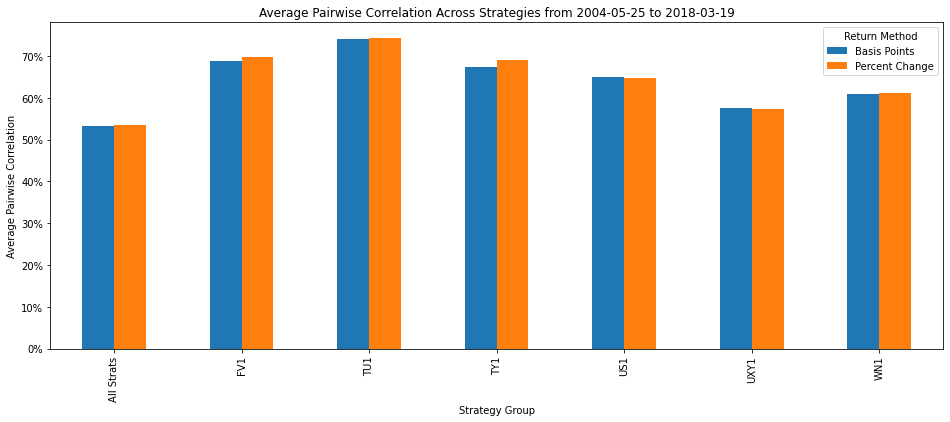

In [10]:
def plot_avg_correlation(df_avg: pd.DataFrame, df_signal: pd.DataFrame) -> plt.Figure: 
    
    _, axes = plt.subplots(figsize = (12,6))

    (df_avg.rename(
        columns = {
            "rtn_type": "Return Method",
            "group": "Strategy Group"}).
        pivot(index = "Strategy Group", columns = "Return Method", values = "avg_corr").
        rename(columns = {
            "PX_BPS": "Basis Points",
            "PX_RTN": "Percent Change"}).
        plot(
            ax = axes,
            kind = "bar",
            figsize = (16,6),
            ylabel = "Average Pairwise Correlation",
            title = "Average Pairwise Correlation Across Strategies from {} to {}".format(
                df_signal.date.min(),
                df_signal.date.max())))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    
plot_avg_correlation(df_avg, df_signal)

In [11]:
def _rolling_correlation(df: pd.DataFrame, window: int):
    
    df_wider = (df[
        ["date", "strat", "signal_rtn"]].
        pivot(index = "date", columns = "strat", values = "signal_rtn"))
    
    correlations = []
    for i in range(len(df_wider) - window):
    
        correlation = (df_wider.iloc[
            i:i+window].
            corr().
            reset_index().
            melt(id_vars = "strat").
            query("value != 1").
            dropna().
            value.
            mean())
        
        correlations.append(correlation)
        
    df_out = (pd.DataFrame({
        "date": df_signal.date.drop_duplicates().to_list()[window:],
        "avg_corr": correlations}))
    
    return df_out

def get_rolling_correlation(df_signal: pd.DataFrame, window: int = 90) -> pd.DataFrame: 

    df_corr = (df_signal.groupby(
        "variable").
        apply(_rolling_correlation, window).
        reset_index().
        drop(columns = ["level_1"]))
    
    return df_corr

df_rolling_corr = get_rolling_correlation(df_signal)

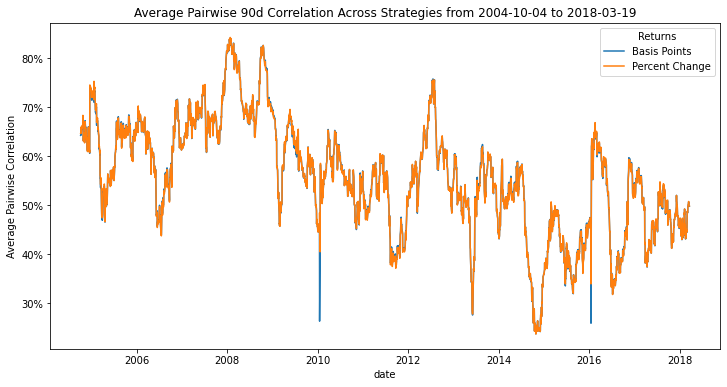

In [12]:
def plot_rolling_correlation(df_rolling_corr: pd.DataFrame, window: int = 90) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (12,6))

    (df_rolling_corr.rename(
        columns = {"variable": "Returns"}).
        pivot(index = "date", columns = "Returns", values = "avg_corr").
        rename(columns = {
            "PX_RTN": "Percent Change",
            "PX_BPS": "Basis Points"}).
        plot(
            ax     = axes,
            ylabel = "Average Pairwise Correlation",
            title  = "Average Pairwise {}d Correlation Across Strategies from {} to {}".format(
                window,
                df_rolling_corr.date.min(),
                df_rolling_corr.date.max())))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    
plot_rolling_correlation(df_rolling_corr)

Now plot the returns of each strategy. In this case percent change is used since the plot will compare stratgies per each Treasury Future rather than across the board

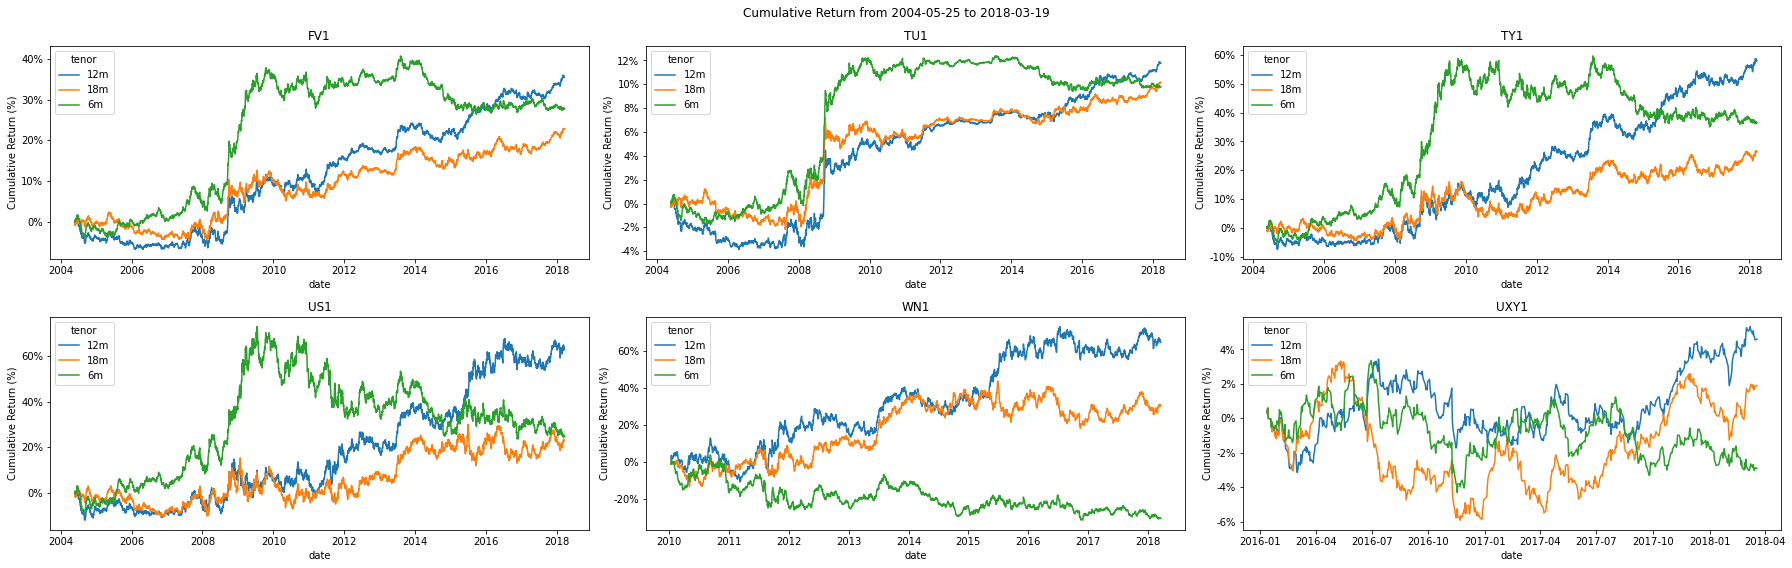

In [13]:
def plot_cumulative_return(df_signal: pd.DataFrame) -> plt.Figure:
    
    df_tmp = df_signal.query("variable == 'PX_RTN'")
    securities = df_signal.security.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(securities) // 2, nrows = len(securities) // 3, figsize = (25,8))

    for security, ax in zip(securities, axes.flatten()):

        (df_tmp.query(
            "security == @security")
            [["date", "tenor", "signal_rtn"]].
            pivot(index = "date", columns = "tenor", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                title  = security,
                ylabel = "Cumulative Return (%)"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
        plt.tight_layout()

    fig.suptitle("Cumulative Return from {} to {}".format(
        df_tmp.date.min(),
        df_tmp.date.max()))

    plt.tight_layout()
    
plot_cumulative_return(df_signal)

In [14]:
def get_strat_sharpe(df_signal: pd.DataFrame, df_tsy: pd.DataFrame) -> pd.DataFrame: 

    df_sharpe = (df_signal.merge(
        right = df_tsy, how = "inner", on = ["date", "security"]).
        assign(signal_bps = lambda x: -1 * x.PX_BPS * np.sign(x.lag_zscore))
        [["strat", "signal_bps"]].
        groupby("strat").
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std": "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        assign(
            future = lambda x: x.strat.str.split(" ").str[0],
            tenor  = lambda x: x.strat.str.split(" ").str[1])
        [["tenor", "future", "sharpe"]])
    
    return df_sharpe

df_strat_sharpe = get_strat_sharpe(df_signal, BoxSpreadData().get_tsy_fut())

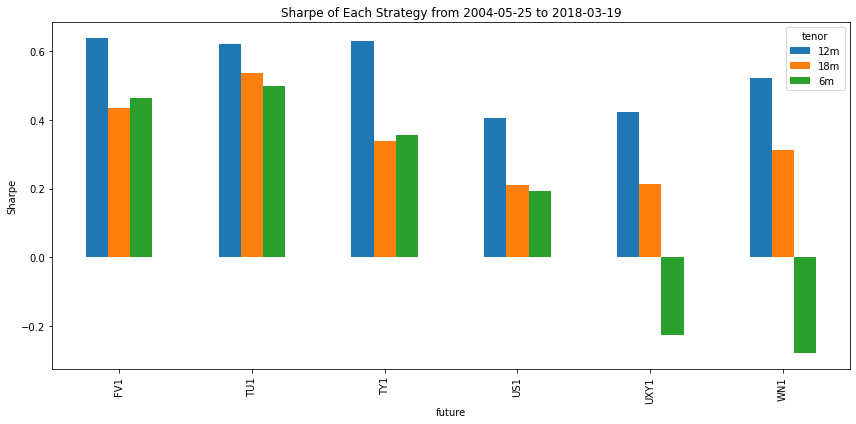

In [15]:
def plot_strategy_sharpe(df_strat_sharpe: pd.DataFrame) -> plt.Figure:
    
    (df_strat_sharpe.pivot(
        index = "future", columns = "tenor", values = "sharpe").
        plot(
            figsize = (12,6),
            kind    = "bar",
            ylabel  = "Sharpe",
            title   = "Sharpe of Each Strategy from {} to {}".format(
                df_signal.date.min(),
                df_signal.date.max())))
    
    plt.tight_layout()
    
plot_strategy_sharpe(df_strat_sharpe)

## Optimizing signals and Portfolio Allocation

In this case using a 30d rolling sharpe and maximizing the strategy with highest sharpe per each Treasury Future. In this case per each security the sharpe is based on percent change returns, while returns comparison in done in cumulative basis points. Since the sharpes are done on a Treasury-Future-basis (same duration) there is no need to change them to basis points, while the ending comparison is in basis points and needs to be used.  

In [16]:
def _get_rolling_sharpe(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            rtn_mean   = lambda x: x.signal_rtn.rolling(window = window).mean(),
            rtn_std    = lambda x: x.signal_rtn.rolling(window = window).std(),
            sharpe     = lambda x: x.rtn_mean / x.rtn_std,
            lag_sharpe = lambda x: x.sharpe.shift()).
        dropna())
    
    return df_out

def get_rolling_sharpe(df_signal: pd.DataFrame, window: int = 90) -> pd.DataFrame: 

    df_sharpe = (df_signal.query(
        "variable == 'PX_RTN'").
        groupby("strat").
        apply(_get_rolling_sharpe, window).
        reset_index(drop = True))
    
    return df_sharpe

df_sharpe = get_rolling_sharpe(df_signal)

In [ ]:
def _max_sharpe(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.query("lag_sharpe == lag_sharpe.max()").tail(1))

def max_sharpe(df_shapre: pd.DataFrame, df_tsy: pd.DataFrame) -> pd.DataFrame: 

    df_max_sharpe = (df_shapre[
        ["date", "tenor", "security", "lag_zscore", "strat", "signal_rtn", "lag_sharpe"]].
        groupby(["date", "security"]).
        apply(_max_sharpe).
        reset_index(drop = True))

    df_combined = (df_tsy[
        ["date", "security", "duration", "PX_BPS"]].
        merge(right = df_max_sharpe, how = "inner", on = ["date", "security"]))
    
    return df_combined

df_max_sharpe = max_sharpe(df_sharpe, BoxSpreadData().get_tsy_fut())

In [ ]:
def plot_max_sharpe_sharpe(df_max_sharpe: pd.DataFrame, window: int = 90) -> pd.DataFrame: 

    (df_max_sharpe.assign(
        signal_bps = lambda x: - 1 * np.sign(x.lag_zscore) * x.PX_BPS)
        [["security", "signal_bps"]].
        groupby("security").
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std": "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        sort_values("sharpe").
        plot(
            figsize = (12,6),
            kind    = "bar",
            legend  = False,
            ylabel  = "Annualize Sharpe",
            title   = "Annualized Sharpe (using Basis points) of {}d Maximized Sharpe Strategy from {} to {}".format(
                window,
                df_max_sharpe.date.min(),
                df_max_sharpe.date.max())))

    plt.tight_layout()
    
plot_max_sharpe_sharpe(df_max_sharpe)

In [ ]:
def plot_cumulative_bps(df_max_sharpe: pd.DataFrame) -> plt.Figure: 
    
    (df_max_sharpe.assign(
        signal_bps = lambda x: - 1 * np.sign(x.lag_zscore) * x.PX_BPS)
        [["date", "security", "signal_bps"]].
        pivot(index = "date", columns = "security", values = "signal_bps").
        cumsum().
        apply(lambda x: x * 100).
        plot(
            figsize = (12,6),
            ylabel  = "Cumulative Basis Points",
            title   = "Comparison of Strategies via Cumulative Basis Points from {} to {}".format(
                df_max_sharpe.date.min(),
                df_max_sharpe.date.max())))

    plt.tight_layout()
    
plot_cumulative_bps(df_max_sharpe)

In [ ]:
def plot_max_sharpe_corr(df_max_sharpe: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (8,6))

    sns.heatmap(df_max_sharpe.assign(
        signal_bps = lambda x: - 1 * np.sign(x.lag_zscore) * x.PX_BPS)
        [["date", "security", "signal_bps"]].
        pivot(index = "date", columns = "security", values = "signal_bps").
        corr(),
        annot = True,
        ax = axes)

    axes.set_title("Correlation of 90d Sharpe Maximized Basis Point Returns\nFrom {} to {}".format(
        df_max_sharpe.date.min(),
        df_max_sharpe.date.max()))
    
    plt.tight_layout()
    
plot_max_sharpe_corr(df_max_sharpe)

To optimize the portfolio just scale the weight by their 30d EWMA rolling volatility. In this case percent change will be used rather than basis points ideally the volatiltiy of the percent change should capture the duration difference. 

In [ ]:
def _get_vol(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            rolling_std     = lambda x: x.signal_rtn.ewm(span = window, adjust = False).std(),
            lag_rolling_std = lambda x: x.rolling_std.shift()).
        dropna())
    
    return df_out

def _erc_weight(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.assign(
        inv_vol      = lambda x: 1 / x.lag_rolling_std,
        weight       = lambda x: x.inv_vol / x.inv_vol.sum(),
        weighted_rtn = lambda x: x.weight * x.signal_rtn))
    
    return df_out

def get_erc_weight(df_max_sharpe: pd.DataFrame, window: int = 30) -> pd.DataFrame: 
    
    df_erc = (df_max_sharpe[
        ["date", "signal_rtn", "security"]].
        groupby("security").
        apply(_get_vol, window).
        reset_index(drop = True).
        groupby("date").
        apply(_erc_weight).
        reset_index(drop = True))
    
    return df_erc

df_erc = get_erc_weight(df_max_sharpe)

In [ ]:
def plot_erc_port(df_erc: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    (df_erc[
        ["date", "weighted_rtn"]].
        groupby("date").
        agg("sum").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes[0],
            legend = False,
            title  = "Cumulative Return",
            ylabel = "Cumulative Returns"))

    (df_erc[
        ["date", "weighted_rtn"]].
        groupby("date").
        agg("sum").
        apply(lambda x: x.rolling(window = 30).std() * np.sqrt(252)).
        plot(
            ax     = axes[1],
            legend = False,
            title  = "30d Rolling Volatility",
            ylabel = "Annaulized Volatility"))

    rtns = (df_erc[
        ["date", "weighted_rtn"]].
        groupby("date").
        agg("sum").
        weighted_rtn)

    sharpe = rtns.mean() / rtns.std() * np.sqrt(252)

    for ax in axes.flatten(): ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    fig.suptitle("Cumulative Returns and Historical Volatility for Equal Risk Contribution Treasury Portfolio from {} to {}\nSharpe: {}".format(
        df_erc.date.min(),
        df_erc.date.max(),
        round(sharpe,3)))

    plt.tight_layout()
    
plot_erc_port(df_erc)

In [ ]:
def _year_cum_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(cum_rtn = lambda x: np.cumprod(1 + x.weighted_rtn) - 1).
        query("date == date.max()"))

def get_year_perf_stats(df_erc: pd.DataFrame) -> plt.Figure:

    df_year_cum = (df_erc[
        ["date", "weighted_rtn"]].
        groupby("date").
        agg("sum").
        reset_index().
        assign(year = lambda x: pd.to_datetime(x.date).dt.year).
        groupby("year").
        apply(_year_cum_rtn).
        reset_index(drop = True)
        [["year", "cum_rtn"]].
        set_index("year"))

    df_year_sharpe = (df_erc[
        ["date", "weighted_rtn"]].
        groupby("date").
        agg("sum").
        reset_index().
        assign(year = lambda x: pd.to_datetime(x.date).dt.year).
        drop(columns = ["date"]).
        groupby("year").
        agg(["mean", "std"])
        ["weighted_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std": "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]])

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    (df_year_cum.plot(
        ax     = axes[0],
        kind   = "bar",
        legend = False,
        ylabel = "Cumulative Return (%)",
        title  = "Cumulative Returns per Year"))

    (df_year_sharpe.plot(
        ax     = axes[1],
        kind   = "bar",
        legend = False,
        ylabel = "Annualized Sharpe",
        title  = "Sharpe per Year"))

    fig.suptitle("Equal Risk Contribution Performance Stats per Each Year from {} to {}".format(
        df_erc.date.min(),
        df_erc.date.max()))

    plt.tight_layout()
    
get_year_perf_stats(df_erc)